In [1]:
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import torchmetrics.classification

from src.EuroSat_dataloaders import transformation_eurosat
from torchvision.datasets import EuroSAT
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader

from src.EuroSat_dataloaders import Train_Dataset_EuroSat,Test_Dataset_EuroSat

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=False)
ds_test = Test_Dataset_EuroSat(ds)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [3]:
vgg = torch.load("finished\\VGG16\\vgg_model.pth")

fc_ = list(vgg.classifier)
fc_.append(torch.nn.Softmax(dim=1))
vgg.fc = torch.nn.Sequential(*fc_)
vgg.eval()

vgg.cuda()



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

DS_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway","Industrial","Pasture","PermanentCrop",
             "Residential", "River", "SeaLake"]
nr = 7
model = vgg
target_layers = [model.features[-3]]
input_tensor = ds_test[nr][0].unsqueeze(0)
print(input_tensor.shape)
y_test = ds_test[nr][1]
prediction = model(input_tensor.cuda())
# print(np.argmax(prediction.cpu().detach().numpy()))
# print(DS_LABELS[np.argmax(prediction.cpu().detach().numpy())])
model2 = torch.load("finished\\VGG16\\vgg_model.pth")
model2.cuda()
fc_ = list(model2.classifier)[:-1]
model2.fc = torch.nn.Sequential(*fc_)
target_layers2 = [model2.features[-3]]
print(model2)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
cam2 = GradCAMPlusPlus(model=model2, target_layers=target_layers2, use_cuda=True)
targets = None #[ClassifierOutputTarget(9)]

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

grayscale_cam = grayscale_cam[0, :] #* (1/np.max(grayscale_cam) if np.max(grayscale_cam) != 0 else 1)

grayscale_cam2 = cam2(input_tensor=input_tensor, targets=targets)

grayscale_cam2 = grayscale_cam2[0, :] #* (1/np.max(grayscale_cam2) if np.max(grayscale_cam2) != 0 else 1)


fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,9)
# ax[0,0].imshow(grayscale_cam)
# ax[0,0].set_title(f"Mapa istotności dla Grad Cam\n {DS_LABELS[np.argmax(prediction.cpu().detach().numpy())]}")
# ax[0,1].imshow((ds_test[nr][0].numpy().T.swapaxes(0,1) + 1)/2)
# ax[0,1].set_title(f"{DS_LABELS[np.argmax(y_test)]}")
visualization = show_cam_on_image((ds_test[nr][0].numpy().T.swapaxes(0,1) +1)/2, grayscale_cam, use_rgb=True)
ax[0,2].imshow(visualization)
ax[1,0].imshow(grayscale_cam2)
ax[1,0].set_title(f"Mapa istotności dla Grad Cam ++\n {DS_LABELS[np.argmax(prediction.cpu().detach().numpy())]}")
ax[1,1].imshow((ds_test[nr][0].numpy().T.swapaxes(0,1) + 1)/2)
ax[1,1].set_title(f"{DS_LABELS[np.argmax(y_test)]}")
visualization = show_cam_on_image((ds_test[nr][0].numpy().T.swapaxes(0,1) +1)/2, grayscale_cam2, use_rgb=True)
ax[1,2].imshow(visualization)
plt.show()

torch.Size([1, 3, 224, 224])
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, st

AxisError: axis 2 is out of bounds for array of dimension 0

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models w

0.0


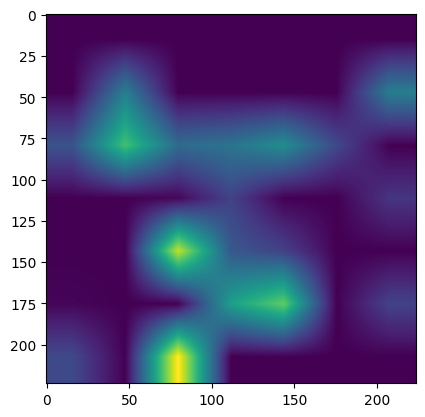

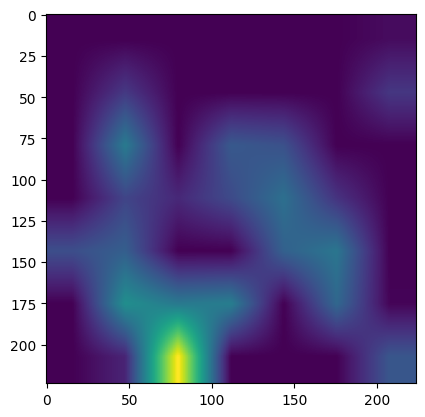

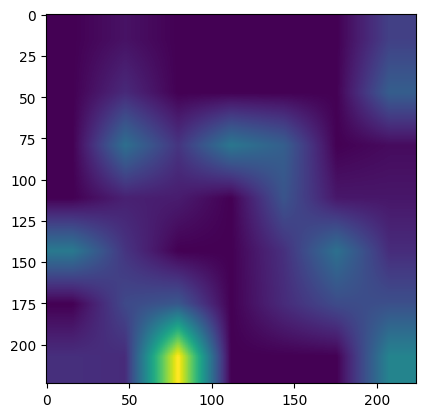

In [6]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

from src.faithfulness.silency_map import Silency_map_gen
# model

resnet50 = torch.load("finished\\ResNet50\\resnet50_model.pth")
resnet50.cuda()

# dataset:

transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=False)
ds_test = Test_Dataset_EuroSat(ds)

# target layer:

target_layers = [resnet50.layer4[-1]]

sil_gen = Silency_map_gen(resnet50, ds_test, target_layers)
plt.imshow(sil_gen.get_silency_map(0))
print(np.min(sil_gen.get_silency_map(0)))
plt.show()
plt.imshow(sil_gen.get_perturbated_silency_map(0))
plt.show()
plt.imshow(sil_gen.get_perturbated_silency_map(0))
plt.show()